In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
from torch import nn

import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, Sampler
import string
import re
import json
from sklearn.utils import shuffle
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

In [2]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

assert torch.cuda.is_available()

NVIDIA GeForce RTX 2080 with Max-Q Design


In [112]:
TEST_DATA_PRIVATE = 'input/test_private_expanded.csv'
TEST_DATA_PUBLIC = 'input/test_public_expanded.csv'
TRAIN_DATA = 'input/train.csv'

# TODO: add also train data analysis for comparison

TEST_DATA = 'input/test_private_expanded.csv'

test = pd.read_csv(TEST_DATA, index_col='id')

train_df = pd.read_csv(TRAIN_DATA, index_col='id')
test_private_df = pd.read_csv(TEST_DATA_PRIVATE, index_col='id')
test_public_df = pd.read_csv(TEST_DATA_PUBLIC, index_col='id')
test_combined_df = pd.concat([test_private_df, test_public_df])

In [4]:
max_len = 220
batch_size = 512
seed = 1029
EMBEDDING_FASTTEXT = './input/crawl-300d-2M.vec'
max_features = 100000
embed_size = 300

ps = PorterStemmer()
lc = LancasterStemmer()
sb = SnowballStemmer('english')

# preprocessing
misspell_dict = {"aren't": "are not", "can't": "cannot", "couldn't": "could not",
                 "didn't": "did not", "doesn't": "does not", "don't": "do not",
                 "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                 "he'd": "he would", "he'll": "he will", "he's": "he is",
                 "i'd": "I had", "i'll": "I will", "i'm": "I am", "isn't": "is not",
                 "it's": "it is", "it'll": "it will", "i've": "I have", "let's": "let us",
                 "mightn't": "might not", "mustn't": "must not", "shan't": "shall not",
                 "she'd": "she would", "she'll": "she will", "she's": "she is",
                 "shouldn't": "should not", "that's": "that is", "there's": "there is",
                 "they'd": "they would", "they'll": "they will", "they're": "they are",
                 "they've": "they have", "we'd": "we would", "we're": "we are",
                 "weren't": "were not", "we've": "we have", "what'll": "what will",
                 "what're": "what are", "what's": "what is", "what've": "what have",
                 "where's": "where is", "who'd": "who would", "who'll": "who will",
                 "who're": "who are", "who's": "who is", "who've": "who have",
                 "won't": "will not", "wouldn't": "would not", "you'd": "you would",
                 "you'll": "you will", "you're": "you are", "you've": "you have",
                 "'re": " are", "wasn't": "was not", "we'll": " will", "tryin'": "trying"}


def _get_misspell(misspell_dict):
    misspell_re = re.compile('(%s)' % '|'.join(misspell_dict.keys()))
    return misspell_dict, misspell_re


def replace_typical_misspell(text):
    misspellings, misspellings_re = _get_misspell(misspell_dict)

    def replace(match):
        return misspellings[match.group(0)]

    return misspellings_re.sub(replace, text)
    

puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']',
          '>', '%', '=', '#', '*', '+', '\\', '•', '~', '@', '£', '·', '_', '{', '}', '©', '^',
          '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 'Â', '█',
          '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶',
          '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼',
          '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
          'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪',
          '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√']


def clean_text(x):
    x = str(x)
    for punct in puncts + list(string.punctuation):
        if punct in x:
            x = x.replace(punct, f' {punct} ')
    return x


def clean_numbers(x):
    return re.sub(r'\d+', ' ', x)

# load dataframe
def load_and_prec(df):
    test = df
    # lower
    test['comment_text'] = test['comment_text'].str.lower()

    # clean misspellings
    test['comment_text'] = test['comment_text'].apply(replace_typical_misspell)

    # clean the text
    test['comment_text'] = test['comment_text'].apply(clean_text)

    # clean numbers
    test['comment_text'] = test['comment_text'].apply(clean_numbers)
    
    # strip
    test['comment_text'] = test['comment_text'].str.strip()
    
    # replace blank with nan
    test['comment_text'].replace('', np.nan, inplace=True)

    
    # fill up the missing values
    test_x = test['comment_text'].fillna('_##_').values
    
    # get the target values
    identity_columns = [
        'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
        'muslim', 'black', 'white', 'psychiatric_or_mental_illness']



    return test_x

class JigsawEvaluator:
    
    def __init__(self, y_binary, y_identity_binary, power=-5, overall_model_weight=0.25):
        self.y = y_binary
        self.y_i = y_identity_binary
        self.n_subgroups = self.y_i.shape[1]
        self.power = power
        self.overall_model_weight = overall_model_weight
        
    @staticmethod
    def _compute_auc(y_true, y_pred):
        try:
            return roc_auc_score(y_true, y_pred)
        except ValueError:
            return np.nan
        
    def _compute_subgroup_auc(self, i, y_pred):
        mask = self.y_i[:, i] == 1
        return self._compute_auc(self.y[mask], y_pred[mask])
        
    def _compute_bpsn_auc(self, i, y_pred):
        mask = self.y_i[:, i] + self.y == 1
        return self._compute_auc(self.y[mask], y_pred[mask])
        
    def _compute_bnsp_auc(self, i, y_pred):
        mask = self.y_i[:, i] + self.y != 1
        return self._compute_auc(self.y[mask], y_pred[mask])
        
    def compute_bias_metrics_for_model(self, y_pred):
        records = np.zeros((3, self.n_subgroups))
        for i in range(self.n_subgroups):
            records[0, i] = self._compute_subgroup_auc(i, y_pred)
            records[1, i] = self._compute_bpsn_auc(i, y_pred)
            records[2, i] = self._compute_bnsp_auc(i, y_pred)
        return records
        
    def _calculate_overall_auc(self, y_pred):
        return roc_auc_score(self.y, y_pred)
        
    def _power_mean(self, array):
        total = sum(np.power(array, self.power))
        return np.power(total / len(array), 1 / self.power)
        
    def get_final_metric(self, y_pred):
        bias_metrics = self.compute_bias_metrics_for_model(y_pred)
        bias_score = np.average([
            self._power_mean(bias_metrics[0]),
            self._power_mean(bias_metrics[1]),
            self._power_mean(bias_metrics[2])
        ])
        overall_score = self.overall_model_weight * self._calculate_overall_auc(y_pred)
        bias_score = (1 - self.overall_model_weight) * bias_score
        return overall_score + bias_score


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def eval_model(model, data_loader):
    model.eval()
    preds_fold = np.zeros(len(data_loader.dataset))

    with torch.no_grad():
        for index, x_batch, y_batch in data_loader:
            x_batch = x_batch.to("cuda")
            y_batch = y_batch.to("cuda")
            y_pred = model(x_batch).detach()
            preds_fold[list(index)] = sigmoid(y_pred.cpu().numpy())[:, 0]

    return preds_fold


class NeuralNet(nn.Module):

    def __init__(self, embedding_matrix):
        super(NeuralNet, self).__init__()

        lstm_hidden_size = 120
        gru_hidden_size = 60
        self.gru_hidden_size = gru_hidden_size

        self.embedding = nn.Embedding(*embedding_matrix.shape)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = nn.Dropout2d(0.2)

        self.lstm = nn.LSTM(embedding_matrix.shape[1], lstm_hidden_size, bidirectional=True, batch_first=True)
        self.gru = nn.GRU(lstm_hidden_size * 2, gru_hidden_size, bidirectional=True, batch_first=True)

        self.linear = nn.Linear(gru_hidden_size * 6, 20)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(20, 1)
        
    def apply_spatial_dropout(self, h_embedding):
        h_embedding = h_embedding.transpose(1, 2).unsqueeze(2)
        h_embedding = self.embedding_dropout(h_embedding).squeeze(2).transpose(1, 2)
        return h_embedding

    def forward(self, x):
        h_embedding = self.embedding(x)
        h_embedding = self.apply_spatial_dropout(h_embedding)

        h_lstm, _ = self.lstm(h_embedding)
        h_gru, hh_gru = self.gru(h_lstm)

        hh_gru = hh_gru.view(-1, self.gru_hidden_size * 2)

        avg_pool = torch.mean(h_gru, 1)
        max_pool, _ = torch.max(h_gru, 1)

        conc = torch.cat((hh_gru, avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)

        return out

class BucketSampler(Sampler):

    def __init__(self, data_source, sort_keys, bucket_size=None, batch_size=1048, shuffle_data=True):
        super().__init__(data_source)
        self.shuffle = shuffle_data
        self.batch_size = batch_size
        self.sort_keys = sort_keys
        self.bucket_size = bucket_size if bucket_size is not None else len(sort_keys)
        self.weights = None

        if not shuffle_data:
            self.index = self.prepare_buckets()
        else:
            self.index = None

    def set_weights(self, weights):
        assert weights >= 0
        total = np.sum(weights)
        if total != 1:
            weights = weights / total
        self.weights = weights

    def __iter__(self):
        indices = None
        if self.weights is not None:
            total = len(self.sort_keys)
            indices = np.random.choice(total, (total,), p=self.weights)
        if self.shuffle:
            self.index = self.prepare_buckets(indices)
        return iter(self.index)

    def get_reverse_indexes(self):
        indexes = np.zeros((len(self.index),), dtype=np.int32)
        for i, j in enumerate(self.index):
            indexes[j] = i
        return indexes

    def __len__(self):
        return len(self.sort_keys)
        
    def prepare_buckets(self, indices=None):
        lens = - self.sort_keys
        assert self.bucket_size % self.batch_size == 0 or self.bucket_size == len(lens)

        if indices is None:
            if self.shuffle:
                indices = shuffle(np.arange(len(lens), dtype=np.int32))
                lens = lens[indices]
            else:
                indices = np.arange(len(lens), dtype=np.int32)

        #  bucket iterator
        def divide_chunks(l, n):
            if n == len(l):
                yield np.arange(len(l), dtype=np.int32), l
            else:
                # looping till length l
                for i in range(0, len(l), n):
                    data = l[i:i + n]
                    yield np.arange(i, i + len(data), dtype=np.int32), data
    
        new_indices = []
        extra_batch = None
        for chunk_index, chunk in divide_chunks(lens, self.bucket_size):
            # sort indices in bucket by descending order of length
            indices_sorted = chunk_index[np.argsort(chunk, axis=-1)]
            batches = []
            for _, batch in divide_chunks(indices_sorted, self.batch_size):
                if len(batch) == self.batch_size:
                    batches.append(batch.tolist())
                else:
                    assert extra_batch is None
                    assert batch is not None
                    extra_batch = batch
    
            # shuffling batches within buckets
            if self.shuffle:
                batches = shuffle(batches)
            for batch in batches:
                new_indices.extend(batch)
    
        if extra_batch is not None:
            new_indices.extend(extra_batch)
        return indices[new_indices]

class TextDataset(Dataset):

    def __init__(self, seqs, targets=None, maxlen=200):
        if targets is not None:
            self.targets = targets
        else:
            self.targets = np.random.randint(2, size=(len(seqs),))
        
        self.seqs = seqs
        self.maxlen = maxlen
        
    def __len__(self):
        return len(self.seqs)
        
    def get_keys(self):
        lens = np.fromiter(
            ((min(self.maxlen, len(seq))) for seq in self.seqs),
            dtype=np.int32)
        return lens
        
    def __getitem__(self, index):
        return index, self.seqs[index], self.targets[index]

def collate_fn(data):
    def _pad_sequences(seqs):
        lens = [len(seq) for seq in seqs]
        max_len = max(lens)

        padded_seqs = torch.zeros(len(seqs), max_len).long()
        for i, seq in enumerate(seqs):
            start = max_len - lens[i]
            padded_seqs[i, start:] = torch.LongTensor(seq)
        return padded_seqs

    index, seqs, targets = zip(*data)
    seqs = _pad_sequences(seqs)
    return index, seqs, torch.FloatTensor(targets)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def eval_model(model, data_loader):
    model.eval()
    preds_fold = np.zeros(len(data_loader.dataset))

    with torch.no_grad():
        for index, x_batch, y_batch in data_loader:
            x_batch = x_batch.to("cuda")
            y_batch = y_batch.to("cuda")
            y_pred = model(x_batch).detach()
            preds_fold[list(index)] = sigmoid(y_pred.cpu().numpy())[:, 0]

    return preds_fold


def tokenize(texts, vocab):

    def text2ids(text, token2id):
        return [
            token2id.get(token, len(token2id) - 1)
            for token in text.split()[:max_len]] + [0] * max(0, max_len - len(text.split()))
    
    return [
        text2ids(text, vocab['token2id'])
        for text in texts]


def load_embedding(embedding_path, word_index):

    def get_coefs(word, *arr):
        return word, np.asarray(arr, dtype='float32')

    embeddings_index = dict(get_coefs(*o.strip().split(' ')) for o in open(embedding_path))
    
    # word_index = tokenizer.word_index
    nb_words = min(max_features + 2, len(word_index))
    embedding_matrix = np.zeros((nb_words, embed_size))

    for key, i in word_index.items():
        word = key
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        word = key.lower()
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        word = key.upper()
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        word = key.capitalize()
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        word = ps.stem(key)
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        word = lc.stem(key)
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        word = sb.stem(key)
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue

    return embedding_matrix


In [5]:
with open('vocab.json', 'r') as f:
    vocab = json.load(f)

embedding_matrix = load_embedding(EMBEDDING_FASTTEXT, vocab['token2id'])

In [6]:
test_data = {"private": test_private_df, "public": test_public_df, "combined": test_combined_df}
test_x = {}
test_dataset = {}
test_sampler = {}
test_loader = {}

for key, df in test_data.items():
    test_x[key] = load_and_prec(df)
    test_x[key] = np.array(tokenize(test_x[key], vocab))
    test_dataset[key] = TextDataset(test_x[key], maxlen=max_len)
    test_sampler[key] = BucketSampler(test_dataset[key], test_dataset[key].get_keys(),
                                 batch_size=batch_size, shuffle_data=False)

    test_loader[key] = DataLoader(test_dataset[key], batch_size=batch_size, sampler=test_sampler[key],
                             shuffle=False, num_workers=0, collate_fn=collate_fn)

/home/dkushn/Ethics_NYU_2024_Spring/respethics/respethics/lib/python3.11/site-packages/torch/utils/data/sampler.py:64: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn("`data_source` argument is not used and will be removed in 2.2.0."


In [8]:
models = torch.load('./experiments/model_baseline.pt')
models.keys()

for name in tqdm(models.keys(), total=len(models), desc='Loading models'):
    new_model = NeuralNet(embedding_matrix).to("cuda")
    new_model.load_state_dict(models[name])
    models[name] = new_model
    models[name].eval()

Loading models: 100%|██████████| 37/37 [00:07<00:00,  4.68it/s]


In [9]:

def inference(comments, models):
    test_x = np.array(tokenize(comments, vocab))
    test_dataset = TextDataset(test_x, maxlen=max_len)
    test_sampler = BucketSampler(test_dataset, test_dataset.get_keys(),
                                 batch_size=batch_size, shuffle_data=False)

    test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler,
                             shuffle=False, num_workers=0, collate_fn=collate_fn)

    preds = []
    ema_preds = []
    
    first_phase_preds = [eval_model(models["model"], test_loader), eval_model(models["ema_model"], test_loader)]


    for name, model in tqdm(models.items(), total=len(models), desc='Evaluating models'):
        # skip first phase
        if name in ["model", "ema_model"]:
            continue

        if name.startswith('ema'):
            ema_preds.append(eval_model(model, test_loader))
        else:
            preds.append(eval_model(model, test_loader))
    preds = np.mean(preds, axis=0)
    ema_preds = np.mean(ema_preds, axis=0)
    return np.mean([preds, ema_preds], axis=0) * 0.9 + np.mean(first_phase_preds, axis=0) * 0.1

In [10]:
for key, df in test_data.items():
    preds = inference(df["comment_text"].to_list(), models)
    df["prediction"] = preds


Evaluating models: 100%|██████████| 37/37 [06:56<00:00, 11.27s/it]
/home/dkushn/Ethics_NYU_2024_Spring/respethics/respethics/lib/python3.11/site-packages/torch/utils/data/sampler.py:64: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn("`data_source` argument is not used and will be removed in 2.2.0."
Evaluating models: 100%|██████████| 37/37 [07:54<00:00, 12.83s/it]
/home/dkushn/Ethics_NYU_2024_Spring/respethics/respethics/lib/python3.11/site-packages/torch/utils/data/sampler.py:64: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn("`data_source` argument is not used and will be removed in 2.2.0."
Evaluating models: 100%|██████████| 37/37 [15:55<00:00, 25.81s/it]


In [ ]:
# preds = inference(test["comment_text"].to_list(), models)
# test["prediction"] = preds

In [17]:
for key, df in test_data.items():
    roc_auc_ = roc_auc_score((df['toxicity'] >= 0.5).astype(int), (df['prediction'] >= 0.5).astype(int)) # TODO: must be by group
    print (key, roc_auc_)

# print(roc_auc_score((test['toxicity'] >= 0.5).astype(int), (test['prediction'] >= 0.5).astype(int))) # TODO: must be by group

private 0.8364739924210273
public 0.829694372778121
combined 0.8332936019791147


# Split the data into different subpopulations and plot distributions

In [18]:
columns_to_remove = ['comment_text', 'created_date', 'publication_id', 'parent_id', 'article_id', 'rating', "identity_annotator_count", "toxicity_annotator_count"]
out_of_competition_traits = ["severe_toxicity", "obscene", "identity_attack", "insult", "threat", "sexual_explicit"]
columns_to_remove += out_of_competition_traits

subpopulations = [i for i in test.columns.to_list() if i not in columns_to_remove]
subpopulations, len(subpopulations)

(['funny',
  'wow',
  'sad',
  'likes',
  'disagree',
  'toxicity',
  'male',
  'female',
  'transgender',
  'other_gender',
  'heterosexual',
  'homosexual_gay_or_lesbian',
  'bisexual',
  'other_sexual_orientation',
  'christian',
  'jewish',
  'muslim',
  'hindu',
  'buddhist',
  'atheist',
  'other_religion',
  'black',
  'white',
  'asian',
  'latino',
  'other_race_or_ethnicity',
  'physical_disability',
  'intellectual_or_learning_disability',
  'psychiatric_or_mental_illness',
  'other_disability'],
 30)

In [19]:
# # We’ll split our data into different subpopulations and plot distributions in Colab.

# import matplotlib.pyplot as plt
# import seaborn as sns

# plot_columns = 3
# plot_rows = len(subpopulations) // plot_columns + 1

# plt.figure(figsize=(12, 40))
# plt.subplots_adjust(hspace=0.5, wspace=0.5)
# for i, subpopulation in enumerate(subpopulations):
#     plt.subplot(plot_rows, plot_columns, i+1)
#     sns.histplot(test[subpopulation], bins=30)#, kde=True)
#     plt.title(subpopulation)

In [20]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# plot_columns = 3
# plot_rows = len(subpopulations) // plot_columns + 1

# plt.figure(figsize=(12, 40))
# plt.subplots_adjust(hspace=0.5, wspace=0.5)
# for i, subpopulation in enumerate(subpopulations):
#     plt.subplot(plot_rows, plot_columns, i+1)
#     # get number of bins 
#     n_bins = 30 #test[subpopulation][test[subpopulation] != test[subpopulation].min()].nunique()
#     sns.histplot(test[subpopulation][test[subpopulation] != test[subpopulation].min()], bins=n_bins)#, kde=True)
#     plt.title(subpopulation)

In [23]:
# percent of values that are 0
mean_representation = {}
for key, df in test_data.items():
    mean_representation[key] = (df[subpopulations] == 0).mean()

mean_representation_df = pd.DataFrame(mean_representation)
mean_representation_df

,private,public,combined
funny,0.861159,0.861344,0.861252
wow,0.961683,0.960501,0.961092
sad,0.921948,0.922277,0.922113
likes,0.412916,0.413615,0.413266
disagree,0.773962,0.773130,0.773546
toxicity,0.701510,0.706176,0.703843
male,0.180425,0.176808,0.178617
female,0.184001,0.181556,0.182778
transgender,0.218598,0.215464,0.217031
other_gender,0.220366,0.217293,0.218830


In [25]:
test_data["combined"].columns

Index(['comment_text', 'created_date', 'publication_id', 'parent_id',
       'article_id', 'rating', 'funny', 'wow', 'sad', 'likes', 'disagree',
       'toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit',
       'identity_attack', 'insult', 'threat', 'identity_annotator_count',
       'toxicity_annotator_count', 'male', 'female', 'transgender',
       'other_gender', 'heterosexual', 'homosexual_gay_or_lesbian', 'bisexual',
       'other_sexual_orientation', 'christian', 'jewish', 'muslim', 'hindu',
       'buddhist', 'atheist', 'other_religion', 'black', 'white', 'asian',
       'latino', 'other_race_or_ethnicity', 'physical_disability',
       'intellectual_or_learning_disability', 'psychiatric_or_mental_illness',
       'other_disability', 'prediction'],
      dtype='object')

In [40]:
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

results_data = {}

for key, df in test_data.items():
    results_data[key] = pd.DataFrame(columns=["subpopulation", "AUC ROC", "False Positive Rate", "False Negative Rate", "Accuracy"])
    for subpopulation in subpopulations:
        if subpopulation in ["toxicity", "prediction"]:
            continue
        if len(df[df[subpopulation] > 0.5]) == 0:
            print(f"No positive cases of subpopulation in {key}", subpopulation)
            continue
        if len((df[df[subpopulation] > 0.5]['toxicity'] >= 0.5).astype(int).value_counts()) == 1:
            print(f"Only one toxic example for subpopulation in {key}", subpopulation)
            continue
        
        fp = ((df[df[subpopulation] > 0.5]['toxicity'] < 0.5) & (df[df[subpopulation] > 0.5]['prediction'] >= 0.5)).sum()
        fn = ((df[df[subpopulation] > 0.5]['toxicity'] >= 0.5) & (df[df[subpopulation] > 0.5]['prediction'] < 0.5)).sum()
        tp = ((df[df[subpopulation] > 0.5]['toxicity'] >= 0.5) & (df[df[subpopulation] > 0.5]['prediction'] >= 0.5)).sum()
        tn = ((df[df[subpopulation] > 0.5]['toxicity'] < 0.5) & (df[df[subpopulation] > 0.5]['prediction'] < 0.5)).sum()


        auc_roc_score = roc_auc_score((df[df[subpopulation] > 0.5]['toxicity'] >= 0.5).astype(int), (df[df[subpopulation] > 0.5]['prediction'] >= 0.5).astype(int))
        false_positive_rate = fp / (fp + tn)
        false_negative_rate = fn / (fn + tp)
        accuracy = (tp + tn) / (tp + tn + fp + fn)

        # Create a new DataFrame with the new rows
        new_rows = pd.DataFrame({"subpopulation": [subpopulation],
                                 "AUC ROC": [auc_roc_score],
                                 "False Positive Rate": [false_positive_rate],
                                 "False Negative Rate": [false_negative_rate],
                                 "Accuracy": [accuracy]})

        # Concatenate the new DataFrame with the original DataFrame
        results_data[key] = pd.concat([results_data[key], new_rows], ignore_index=True)

results_data['private']

No positive cases of subpopulation in private other_gender
No positive cases of subpopulation in private other_sexual_orientation
Only one toxic example for subpopulation in private other_religion
Only one toxic example for subpopulation in private physical_disability
Only one toxic example for subpopulation in private intellectual_or_learning_disability
No positive cases of subpopulation in private other_disability
No positive cases of subpopulation in public other_gender
No positive cases of subpopulation in public other_sexual_orientation
Only one toxic example for subpopulation in public other_religion
Only one toxic example for subpopulation in public other_race_or_ethnicity
Only one toxic example for subpopulation in public physical_disability
Only one toxic example for subpopulation in public intellectual_or_learning_disability
No positive cases of subpopulation in public other_disability
No positive cases of subpopulation in combined other_gender
No positive cases of subpopulat

,subpopulation,AUC ROC,False Positive Rate,False Negative Rate,Accuracy
0,funny,0.837922,0.022773,0.301382,0.954855
1,wow,0.816492,0.023908,0.343109,0.946903
2,sad,0.823013,0.024756,0.329218,0.946024
3,likes,0.823526,0.021411,0.331536,0.954424
4,disagree,0.822518,0.024698,0.330266,0.948132
5,male,0.772854,0.037332,0.416961,0.906625
6,female,0.778424,0.023212,0.419940,0.923014
7,transgender,0.712366,0.075269,0.500000,0.837607
8,heterosexual,0.840909,0.068182,0.250000,0.892857
9,homosexual_gay_or_lesbian,0.708907,0.075145,0.507042,0.799180


In [56]:
# case A:
# labels = subpopulations
# labels.remove('toxicity')
# labels.remove('prediction')

# case B:
labels = identity_columns

bias_metrics = {}
overall_auc = {}
for key, df in test_data.items():
    bias_metrics[key] = {}
    test_y_identity_binary = (df[labels].values >= 0.5).astype(int)
    test_y_binary = (df['toxicity'].values >= 0.5).astype(int)
    evaluator = JigsawEvaluator(test_y_binary, test_y_identity_binary)
    
    test_nan_mask = df == '_##_'
    assert test_nan_mask.values.sum() == 0

    overall_auc[key] = evaluator._calculate_overall_auc(df["prediction"])
    bias_metrics_dict = evaluator.compute_bias_metrics_for_model(df["prediction"])
    bias_metrics[key] = pd.DataFrame(bias_metrics_dict, index=["Subgroup_AUC", "BPSN_AUC", "BNSP_AUC"], columns=labels)


In [60]:
bias_metrics['combined']

,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness
Subgroup_AUC,0.926783,0.936878,0.846207,0.945133,0.919489,0.875941,0.857845,0.870107,0.925250
BPSN_AUC,0.952674,0.961249,0.898955,0.967997,0.944118,0.919214,0.885209,0.896128,0.931262
BNSP_AUC,0.957425,0.955850,0.958942,0.952781,0.959865,0.959340,0.967532,0.967663,0.968772


In [61]:
bias_metrics['public']

,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness
Subgroup_AUC,0.924933,0.934857,0.846999,0.946266,0.928208,0.895614,0.859239,0.875779,0.900278
BPSN_AUC,0.952606,0.958334,0.896844,0.967188,0.946509,0.918229,0.871877,0.894011,0.925083
BNSP_AUC,0.956545,0.957160,0.959691,0.954294,0.962221,0.965325,0.971576,0.969131,0.961179


In [62]:
bias_metrics['private']

,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness
Subgroup_AUC,0.929150,0.938965,0.844409,0.943938,0.910821,0.855740,0.856216,0.863264,0.946961
BPSN_AUC,0.952718,0.964037,0.900879,0.968860,0.941736,0.920468,0.897919,0.898213,0.937887
BNSP_AUC,0.958613,0.954651,0.958159,0.951316,0.957288,0.952754,0.963243,0.966051,0.976276


In [125]:
diff = bias_metrics['private'] - bias_metrics['public']
diff

,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness
Subgroup_AUC,0.004217,0.004108,-0.002589,-0.002328,-0.017387,-0.039875,-0.003023,-0.012515,0.046682
BPSN_AUC,0.000112,0.005703,0.004034,0.001672,-0.004772,0.002239,0.026042,0.004202,0.012805
BNSP_AUC,0.002068,-0.002510,-0.001532,-0.002978,-0.004933,-0.012571,-0.008333,-0.003079,0.015097


In [64]:
results = results_data['combined']
selected_rows = results[results["subpopulation"].isin(identity_columns)]
selected_rows.set_index("subpopulation").T

subpopulation,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness
AUC ROC,0.766717,0.771612,0.707799,0.722610,0.735562,0.715793,0.718407,0.731150,0.792904
False Positive Rate,0.039431,0.025555,0.067797,0.018697,0.028875,0.050871,0.092973,0.075077,0.048338
False Negative Rate,0.427136,0.431221,0.516605,0.536082,0.500000,0.517544,0.470213,0.462623,0.365854
Accuracy,0.902267,0.920149,0.807967,0.927106,0.891414,0.836594,0.779928,0.807198,0.888620


In [65]:
results = results_data['public']
selected_rows = results[results["subpopulation"].isin(identity_columns)]
selected_rows.set_index("subpopulation").T

subpopulation,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness
AUC ROC,0.761146,0.762689,0.698295,0.720400,0.748965,0.730675,0.728643,0.739530,0.736410
False Positive Rate,0.041403,0.028420,0.060773,0.017094,0.023810,0.051471,0.103896,0.074074,0.040000
False Negative Rate,0.436306,0.446203,0.542636,0.542105,0.478261,0.487179,0.438819,0.446866,0.487179
Accuracy,0.898198,0.916388,0.812627,0.928337,0.898765,0.836980,0.782546,0.812292,0.878505


In [66]:
results = results_data['private']
selected_rows = results[results["subpopulation"].isin(identity_columns)]
selected_rows.set_index("subpopulation").T

subpopulation,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness
AUC ROC,0.772854,0.778424,0.708907,0.727243,0.721381,0.704564,0.710036,0.720894,0.843247
False Positive Rate,0.037332,0.023212,0.075145,0.020262,0.034161,0.050331,0.082073,0.078680,0.057692
False Negative Rate,0.416961,0.419940,0.507042,0.525253,0.523077,0.540541,0.497854,0.479532,0.255814
Accuracy,0.906625,0.923014,0.799180,0.926439,0.883721,0.838280,0.778736,0.800000,0.899497


In [126]:
diff2 = results_data['private'].T - results_data['public'].T
diff2[identity_columns] 

subpopulation,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness
AUC ROC,0.011708,0.015736,0.010611,0.006842,-0.027584,-0.026111,-0.018606,-0.018636,0.106837
False Positive Rate,-0.004071,-0.005208,0.014371,0.003168,0.010352,-0.001139,-0.021823,0.004606,0.017692
False Negative Rate,-0.019345,-0.026263,-0.035593,-0.016853,0.044816,0.053361,0.059036,0.032666,-0.231366
Accuracy,0.008427,0.006626,-0.013447,-0.001898,-0.015045,0.001300,-0.003811,-0.012292,0.020993


### We observe that scores for private dataset are better. But data are stubborn...

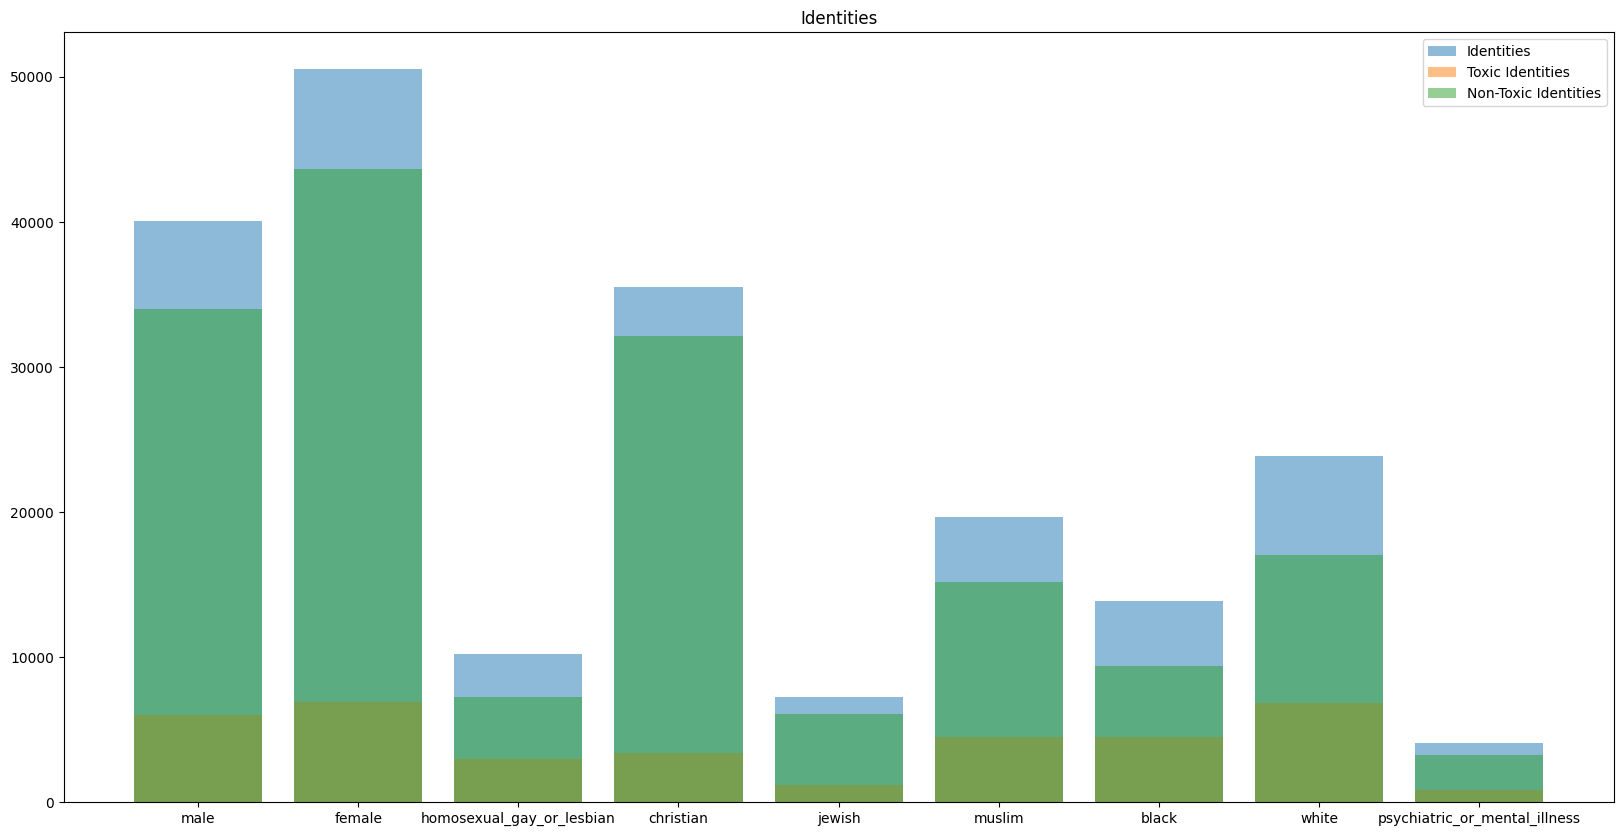

In [115]:
# plot the bias metric['combined'] and number of positive and negative examples in each group.
# Side-by-side comparison of the bias metric and the number of positive and negative examples in each group.

import matplotlib.pyplot as plt
import seaborn as sns

# plot_columns = 3
# plot_rows = len(identity_columns) // plot_columns + 1

identities = []
toxic_identities = []
non_toxic_identities = []
subgroup_AUC = []
subgroup_bnsp_auc = []
subgroup_bpsn_auc = []
# df = test_data['combined']
df = train_df
for subpopulation in identity_columns:
    identities.append(df[df[subpopulation] > 0.5].shape[0])
    toxic_identities.append(df[(df[subpopulation] > 0.5) & (df['target'] >= 0.5)].shape[0])
    non_toxic_identities.append(df[(df[subpopulation] > 0.5) & (df['target'] < 0.5)].shape[0])

    subgroup_AUC.append(bias_metrics['combined'].loc["Subgroup_AUC", subpopulation])
    subgroup_bnsp_auc.append(bias_metrics['combined'].loc["BNSP_AUC", subpopulation])
    subgroup_bpsn_auc.append(bias_metrics['combined'].loc["BPSN_AUC", subpopulation])

plt.figure(figsize=(20, 10))
plt.bar(identity_columns, identities, alpha=0.5, label='Identities')
plt.bar(identity_columns, toxic_identities, alpha=0.5, label='Toxic Identities')
plt.bar(identity_columns, non_toxic_identities, alpha=0.5, label='Non-Toxic Identities')
plt.legend(loc='upper right')
plt.title('Identities')
plt.show()

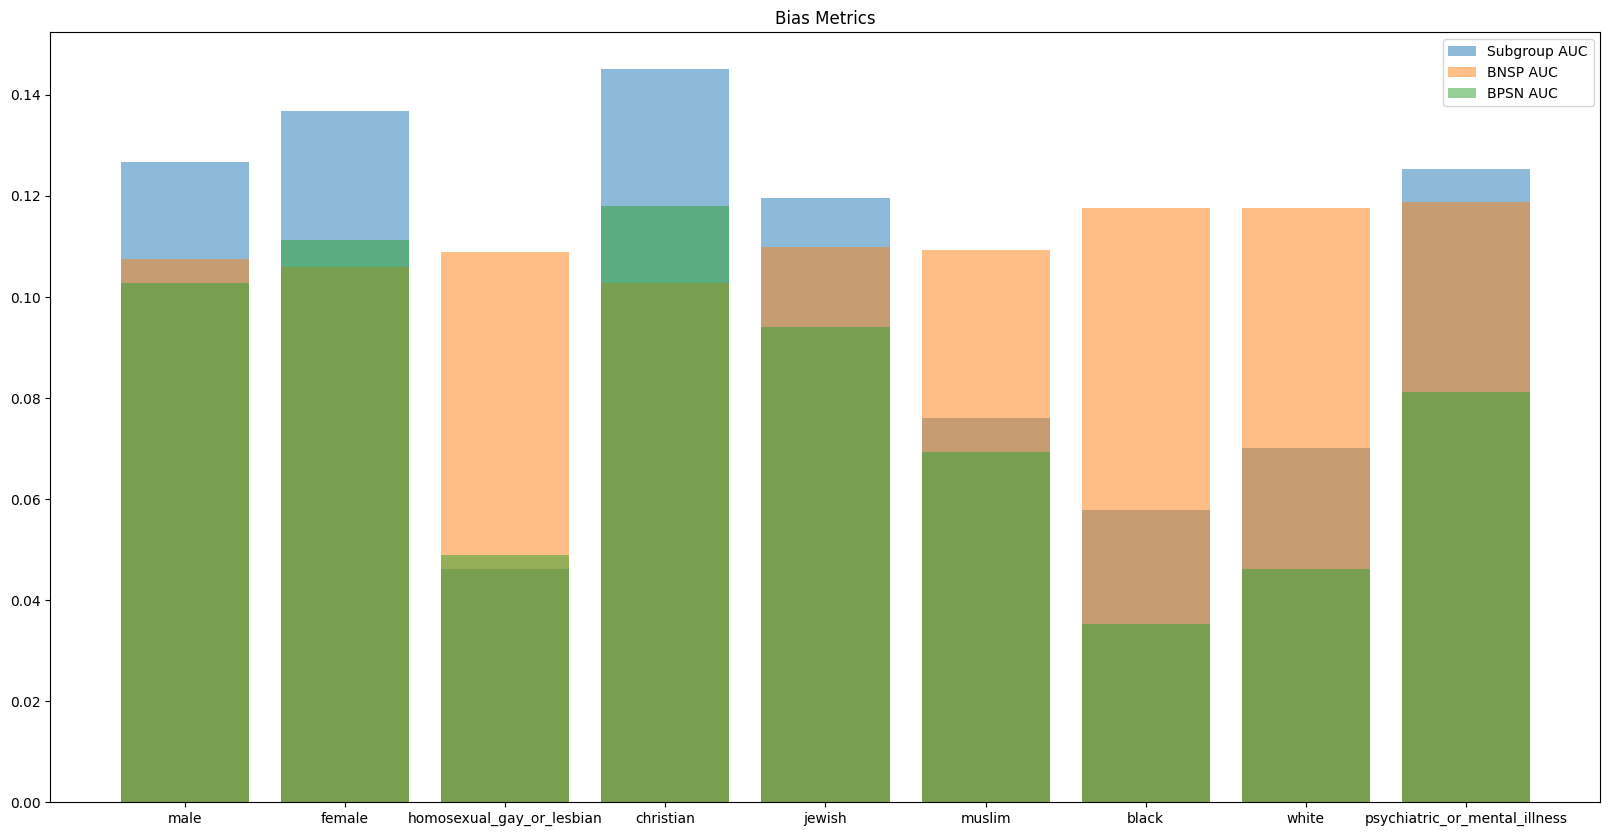

In [110]:
subgroup_AUC = np.array(subgroup_AUC) - 0.8
subgroup_bnsp_auc = np.array(subgroup_bnsp_auc) - 0.85
subgroup_bpsn_auc = np.array(subgroup_bpsn_auc) - 0.85

# plot AUC, BNSP_AUC, BPSN_AUC
plt.figure(figsize=(20, 10))
plt.bar(identity_columns, subgroup_AUC, alpha=0.5, label='Subgroup AUC')
plt.bar(identity_columns, subgroup_bnsp_auc, alpha=0.5, label='BNSP AUC')
plt.bar(identity_columns, subgroup_bpsn_auc, alpha=0.5, label='BPSN AUC')
plt.legend(loc='upper right')
plt.title('Bias Metrics')
plt.show()

### There is some analogies between amount of training data and what we see in bias metrics, but some relations are harder to explain.